<!-- <a href="https://colab.research.google.com/github/steflhermitte/EO-Notebooks/blob/master/PhysicalPrinciplesofEO/Radiative_Transfer_Modelling_wih_Prosail_py6S.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a> -->


[<img src="https://raw.githubusercontent.com/mbakker7/exploratory_computing_with_python/master/tudelft_logo.png" width="200" align='right'>](https://www.tudelft.nl/citg/over-faculteit/afdelingen/geoscience-remote-sensing/staff/scientific-staff/dr-stef-lhermitte)


# Radiative transfer modelling using prosail/6S  
*Created by Stef Lhermitte (s.lhermitte at tudelft.nl / [@steflhermitte](https://twitter.com/StefLhermitte) | www.earthmapps.io)*

[![Twitter](https://img.shields.io/twitter/url/https/twitter.com/cloudposse.svg?style=social&label=%20%40steflhermitte)](https://twitter.com/steflhermitte)

*Adapted (and cleaned up a bit) for PPESO by Paco Lopez-Dekker*



## General packages
Import general packages

In [1]:
import matplotlib.pyplot as plt
import numpy
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd

# Prosail
The [PROSAIL](http://teledetection.ipgp.jussieu.fr/prosail/) model, a fusion of PROSPECT (leaf reflectance and transmittance) and SAIL (plant canopy reflectance), has been used for the last thirty years to simulate the spectral and directional reflectance of plant canopies in the solar domain. It links the spectral dimension of the reflectance, which is mainly related to the biochemical content of the leaves, to the directional dimension, which is mainly related to the architecture of the canopy. PROSAIL has been widely used to develop new methods to retrieve biophysical properties of vegetation and to prepare new space missions. 

In [2]:
# Load PROSPECT+SAIL Radiative transfer mode package
import prosail

Once `prosail` is imported, we can run a radiative transfer simulation the surface reflectance would at the bottom of atmosphere (i.e., just above the canopy) by setting the canopy properties. `prosail` takes a set of arguments:

Argument | explanation
--- | ---
n: float | Leaf layers
cab: float | leaf chlorophyll concentration
car: float | leaf carotenoid concentration
cbrown: float | senescent pigment
cw: float | equivalent leaf water
cm: float | leaf dry matter
lai: float | leaf area index
lidfa: float | a parameter for leaf angle distribution. If ``typliedf``=2, average leaf inclination angle.
tts: float | Solar zenith angle
tto: float | Sensor zenith angle
psi: float | Relative sensor-solar azimuth angle ( saa - vaa )
ant: float | leaf anthocyanin concentration (default set to 0)
alpha: float | The alpha angle (in degrees) used in the surface scattering calculations. By default it's set to 40 degrees.
prospect_version: str | Which PROSPECT version to use. We have "5" and "D"
typelidf: int, optional | The type of leaf angle distribution function to use. By default, is set to 2.
lidfb: float, optional | b parameter for leaf angle distribution. If ``typelidf``=2, ignored factor: str, optional
rsoil0: float, optional | The soil reflectance spectrum
rsoil: float, optional | Soil scalar 1 (brightness)
psoil: float, optional | Soil scalar 2 (moisture)
soil_spectrum1: 2101-element array |  First component of the soil spectrum
soil_spectrum2: 2101-element array | Second component of the soil spectrum


You can find a background on the `prosail` model settings on https://doi.org/10.1016/j.rse.2008.01.026:

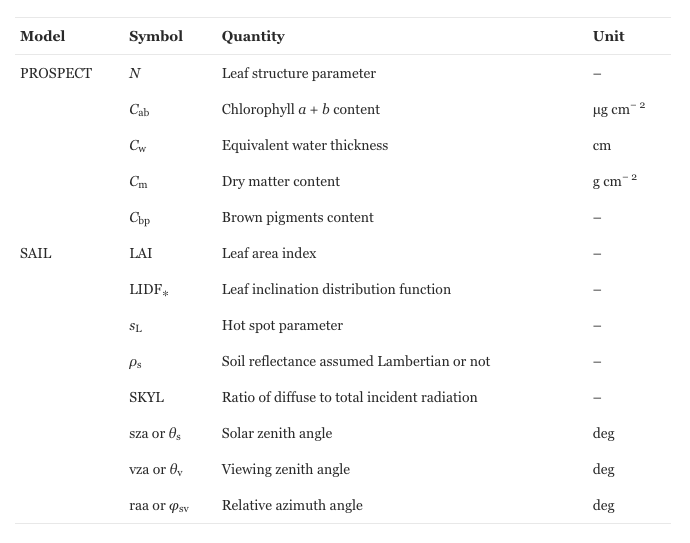

Prosail can return different reflectances:

Setting | meaning
--- | ---
SDR | directional reflectance factor (default)
BHR |  bi-hemispherical r. f.
DHR |  Directional-Hemispherical r. f. (directional illumination)
HDR | Hemispherical-Directional r. f. (directional view)
ALL | All of them
ALLALL | All of the terms calculated by SAIL, including the above

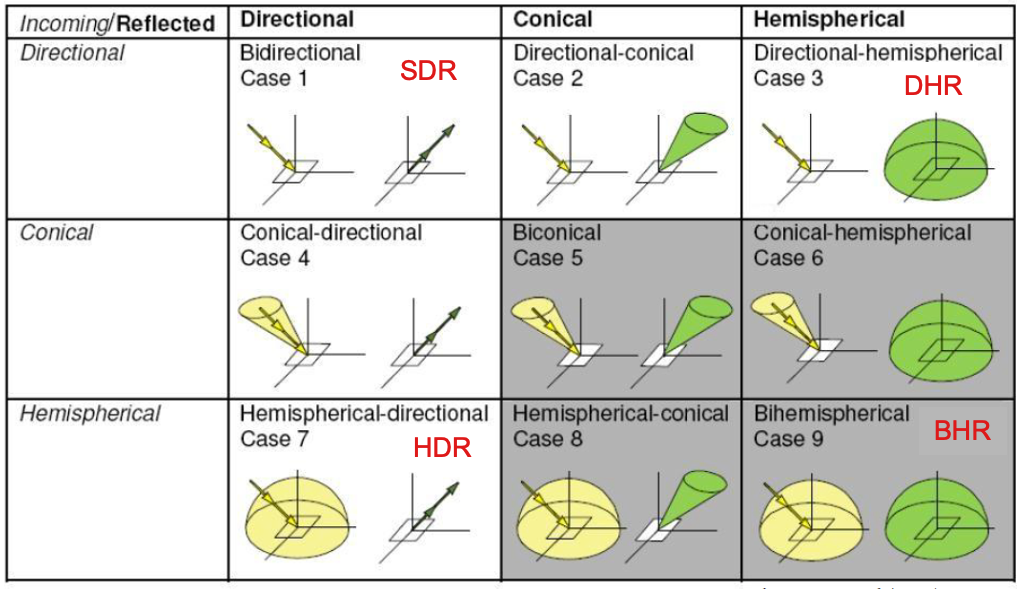

The soil model is a fairly simple linear mixture model, where two default spectra are mixed and then a brightness term added:

`rho_soil = rsoil*(psoil*soil_spectrum1+(1-psoil)*soil_spectrum2)`

The idea is that one of the spectra is a dry soil and the other a wet soil, so soil moisture is then controlled by psoil. rsoil is just a brightness scaling term.

With these settings we can run the prosail model and asses the input of the soil leaf canopy features

Text(0, 0.5, 'Reflectance []')

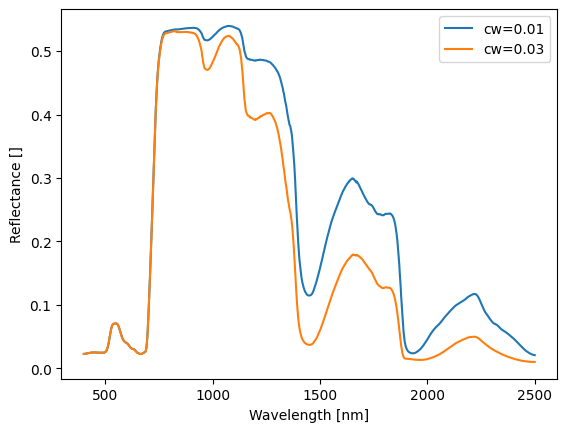

In [27]:
# Run the prosail model
rr1 = prosail.run_prosail(n=1.5, cab=40, car=8.0, cbrown=0.0, cw=0.01, cm=0.009, lai=3.00, lidfa=0.35, 
                         hspot=0.01, # hotspot parameter
                         tts=30, tto=10, psi=0, # observation geometry
                         rsoil=1.0, psoil=1.0, # soil description
                         factor="SDR")
wls_prosail = np.arange(400, 2501) # In nanometer
rr2 = prosail.run_prosail(n=1.5, cab=40, car=8.0, cbrown=0.0, cw=0.03, cm=0.009, lai=3.00, lidfa=0.35, 
                         hspot=0.01, # hotspot parameter
                         tts=30, tto=10, psi=0, # observation geometry
                         rsoil=1.0, psoil=1.0, # soil description
                         factor="SDR")
plt.plot(wls_prosail, rr1, label='cw=0.01')
plt.plot(wls_prosail, rr2, label='cw=0.03')
plt.legend()
plt.xlabel("Wavelength [nm]")
plt.ylabel("Reflectance []")

## Dependence on observation geometry

Let us consider the Sentine-2 case, whose orbit results in (ascending) acquisitons at 10:30 local time. Let us assume that the Sentinel-2 looks straight down (`tto=0`). The solar zenit angle will change over time. The solar zenit angle will change during the year, being large in the winter (i.e. low elevation) and small in the summer.
Do we expect the azimuth angle to be relevant?

In [4]:
elevations = np.linspace(1, 89, 10)
rr_vs_el = np.zeros((10, rr.size))
for elind in range(10):
    r_ = prosail.run_prosail(n=1.5, cab=40, car=8.0, cbrown=0.0, cw=0.01, cm=0.009, lai=1, lidfa=0.35, 
                             hspot=0.5, # hotspot parameter
                             tts=90 - elevations[elind], tto=0, psi=0, # observation geometry
                             rsoil=0.5, psoil=1, # soil description
                             factor="SDR") 
    rr_vs_el[elind] = r_

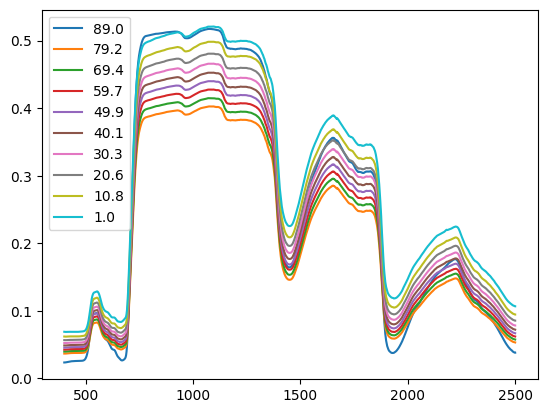

In [5]:
plt.figure()
wls = np.arange(rr.size)
for elind in range(10):
    plt.plot(wls_prosail,rr_vs_el[elind], label=("%2.1f" % (90 - elevations[elind])))
plt.legend()

For example, we can compare the differences in Leaf Area Index (LAI):

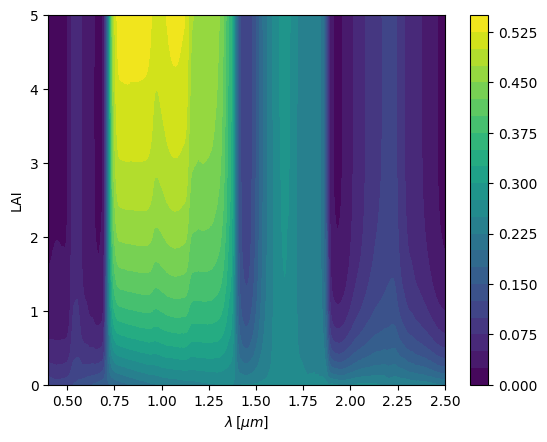

In [6]:
nlai = 40
LAIs = np.linspace(0, 5, nlai)

rr_vs_lai = np.zeros((nlai, rr.size))
for laiind in range(nlai):
    r_ = prosail.run_prosail(n=1.5, cab=40, car=8.0, cbrown=0.0, cw=0.01, cm=0.009, lai=LAIs[laiind], lidfa=0.35, 
                             hspot=0.01, # hotspot parameter
                             tts=45, tto=0, psi=0, # observation geometry
                             rsoil=0.5, psoil=1, # soil description
                             factor="SDR") 
    rr_vs_lai[laiind] = r_

plt.contourf(wls_prosail/1000, LAIs, rr_vs_lai, 20)
plt.xlabel("$\lambda\, [\mu m]$")
plt.ylabel("LAI")
plt.colorbar()



In [7]:
?prosail.run_prosail

Signature:
prosail.run_prosail(
    n,
    cab,
    car,
    cbrown,
    cw,
    cm,
    lai,
    lidfa,
    hspot,
    tts,
    tto,
    psi,
    ant=0.0,
    alpha=40.0,
    prospect_version='5',
    typelidf=2,
    lidfb=0.0,
    factor='SDR',
    rsoil0=None,
    rsoil=None,
    psoil=None,
    soil_spectrum1=None,
    soil_spectrum2=None,
)
Docstring:
Run the PROSPECT_5B and SAILh radiative transfer models. The soil
model is a linear mixture model, where two spectra are combined together as

     rho_soil = rsoil*(psoil*soil_spectrum1+(1-psoil)*soil_spectrum2)
By default, ``soil_spectrum1`` is a dry soil, and ``soil_spectrum2`` is a
wet soil, so in that case, ``psoil`` is a surface soil moisture parameter.
``rsoil`` is a  soil brightness term. You can provide one or the two
soil spectra if you want.  The soil spectra must be defined
between 400 and 2500 nm with 1nm spacing.

Parameters
----------
n: float
    Leaf layers
cab: float
    leaf chlorophyll concentration
car: float
   

# Py6S

[Py6S](https://py6s.readthedocs.io/en/latest/) is a interface to the Second Simulation of the Satellite Signal in the Solar Spectrum ([6S](https://en.wikipedia.org/wiki/6S_(radiative_transfer_code))) atmospheric Radiative Transfer Model through the Python programming language. It allows you to run 6S simulations. 6S is an advanced radiative transfer code designed to simulate the reflection of solar radiation by a coupled atmosphere-surface system for a wide range of atmospheric, spectral and geometrical conditions. It belongs to the group of procedures called Atmospheric correction for the process of removing the effects of the atmosphere on the reflectance values of images taken by satellite or airborne sensors. 

In [8]:
# Load the Py6S module
import Py6S as p6s
p6s.SixS.test()

6S wrapper script by Robin Wilson
Using 6S located at C:\Users\jxie3\miniconda3\envs\py6s-env\Library\bin\sixs.exe
Running 6S using a set of test parameters
6sV version: 1.1
The results are:
Expected result: 619.158000
Actual result: 619.158000
#### Results agree, Py6S is working correctly


0

6S simulates the radiative transfer components across the whole atmosphere for different wavelengths. The SixS class is at the heart of Py6S. It has methods and attributes that allow you to set 6S parameters, run 6S and then view the outputs.

Py6S sets every 6S parameter to a sensible default, so the simplest possible code just uses the default values. As a nice introduction, we’re going to plot one of the 6S outputs across the whole Visible-NIR wavelength range:

Running for many wavelengths - this may take a long time


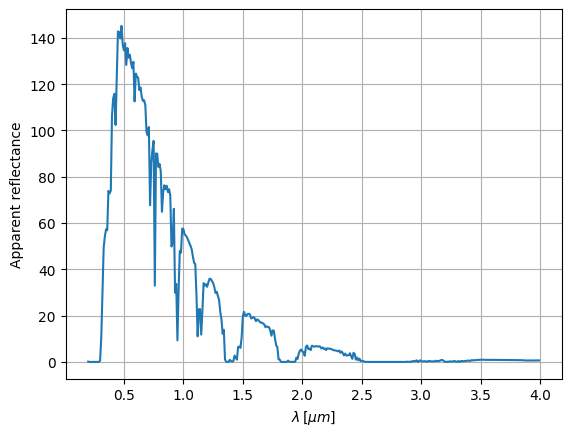

In [9]:
# Create a SixS object called s (used as the standard name by convention)
s = p6s.SixS()
# Run the 6S simulation defined by this SixS object across the
# whole VIS range
wavelengths, results = p6s.SixSHelpers.Wavelengths.run_whole_range(s, output_name="pixel_radiance")
# Plot these results, with the y axis label set to "Pixel Radiance"
# We could use the helper function
# p6s.SixSHelpers.Wavelengths.plot_wavelengths(wavelengths, results, "Pixel Radiance")
# But I (PLD) prefer to have full control of my plots
plt.figure()
plt.plot(wavelengths, results)
plt.xlabel(r"$\lambda\,[\mu m]$")
plt.ylabel("Apparent reflectance")
plt.grid()

## 6S inputs

We can subsequently change the input parameters to modify the atmosphere or background etc:

In [10]:
s.atmos_profile = p6s.AtmosProfile.PredefinedType(p6s.AtmosProfile.Tropical)
s.wavelength = p6s.Wavelength(0.357)
s.run()
print(s.outputs.pixel_radiance)

59.344


ou can see here that we have changed the atmospheric profile to a pre-defined profile called ‘Tropical’, and changed the wavelength that we are using for the simulation to 0.357 micrometres. You can also see that here we’re accessing the outputs directly, rather than running it over a specific wavelength range and plotting it. 

In [11]:
s.outputs.direct_solar_irradiance

208.329

Lets have a look at the input parameters that we can change, summarised in the table below:

SixS | Parameter |	Description	Possible values
--- | --- | ---
atmos_profile	| Atmospheric profile (pressure, water vapour, ozone etc)	| Any outputs from AtmosProfile
aero_profile | Aerosol profile (types, distributions etc)	| Any outputs from AeroProfile
ground_reflectance |	Ground reflectance (Homogeneity, BRDF etc.)	| Any outputs from GroundReflectance
geometry	| Viewing/Illumination geometry (manual or satellite-specific) |	A Geometry* class, for example Geometry.User
aot550	| Aerosol Optical Thickness at 550nm	| Floating point number
visibility	| Visibility in km	| Floating point number
altitude	| Altitudes of the sensor and target	| An instance of the Altitudes class
atmos_corr	| Atmospheric correction settings (yes/no, reflectances)	| Any outputs from AtmosCorr


For example we can change the atmospheric profiles and specify some specific satellite wavelengths.

In [12]:
s.atmos_profile = p6s.AtmosProfile.UserWaterAndOzone(3.6, 0.9) # Set the atmosphere profile to be based on 3.6cm of water and 0.9cm-atm of ozone
s.wavelength = p6s.Wavelength(p6s.PredefinedWavelengths.LANDSAT_TM_B3) # Set the wavelength to be that of the Landsat TM Band 3 - includes response function
# Set the viewing/solar geometry
s.geometry.view_z = 45 # Set the viewing zenith angle
s.geometry.solar_z = 45 # Set the solar zenith angle
# Set the altitudes of target and satellite
s.altitudes.set_target_sea_level() # Put the target at sea
s.altitudes.set_sensor_satellite_level() # Put the sensor at satellite level
s.run()
print(s.outputs.pixel_radiance)

37.392


Or we can set the `GroundReflectance` to the reflectance we model with `prosail`:

Running for many wavelengths - this may take a long time


<Figure size 640x480 with 0 Axes>

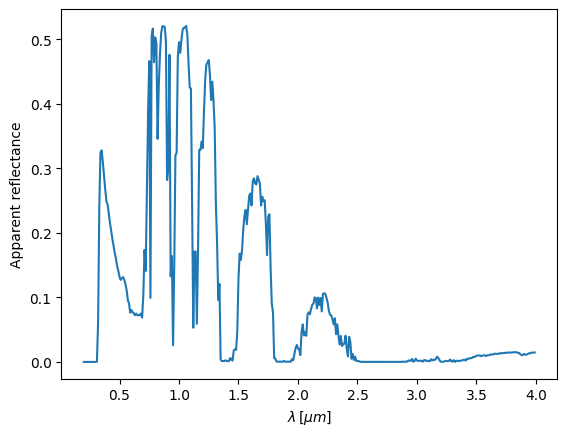

<Figure size 640x480 with 0 Axes>

In [13]:
spectrum = np.transpose(np.vstack( (wls_prosail/1000.0, rr) ))
# Perform a 6S simulation with the simulated GroundReflectance
s.ground_reflectance = p6s.GroundReflectance.HomogeneousLambertian(spectrum)
# Get the output
wavelengths, results = p6s.SixSHelpers.Wavelengths.run_whole_range(s, output_name="apparent_reflectance")
# Plot these results, with the y axis label set to "Pixel Radiance"
plt.figure()
plt.plot(wavelengths, results)
plt.xlabel(r"$\lambda\,[\mu m]$")
plt.ylabel("Apparent reflectance")
plt.figure()

## 6S outputs
The outputs from the 6S model are available under the s.outputs attribute and you can explore the by typing `s.outputs.` and pressing `CTRL+SPACE`.

It is often necessary to run a simulation across a number of wavelengths - as it is very rare that we are only interested in a single wavelength. We saw an example of this above, when we used the `run_whole_range` method to run a simulation across the Visible-NIR wavelengths. We can do similar things for other wavelengths really easily. For example:

In [14]:
# for the vnir range only
ws, res = p6s.SixSHelpers.Wavelengths.run_vnir(s, output_name="pixel_radiance")
# for the whole range, but at a coarser resolution, so that it's quicker
# wv, res = SixSHelpers.Wavelengths.run_whole_range(s, spacing=0.030, output_name='pixel_radiance')
# Run for the Landsat TM bands
# wv, res = SixSHelpers.Wavelengths.run_landsat_tm(s, output_name='pixel_radiance')
# Run for the Sentinel-2 bands
wv, res = p6s.SixSHelpers.Wavelengths.run_s2a_msi(s, output_name='pixel_radiance')

Running for many wavelengths - this may take a long time
Running for many wavelengths - this may take a long time


## Example: end-to-end
With all this info we can run a simulation where we compare the 6S Top of Atmosphere (TOA) reflectance with the prosail bottom of atmosphere reflectance and the output of Sentinel-2 only:

Running for many wavelengths - this may take a long time
Running for many wavelengths - this may take a long time


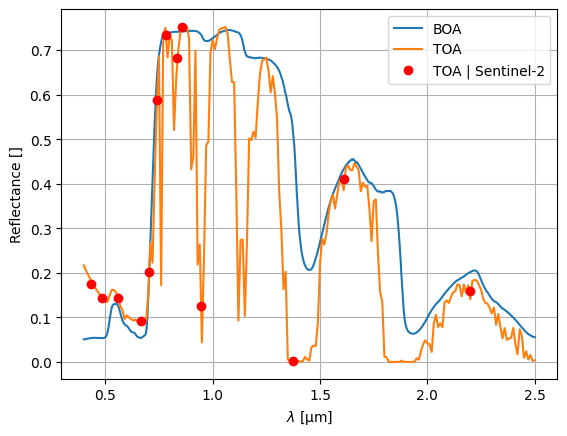

In [29]:
# Run prosail
rr = prosail.run_prosail(n=1.5, cab=40, car=8.0, cbrown=0.0, cw=0.01, cm=0.009, lai=3.00, lidfa=0.35, hspot=0.01, tts=0, tto=0, psi=0, rsoil=1.0, psoil=1.0, factor="SDR") 
# Make a spectrum which combines the wavelengths with the reflectance
spectrum = np.transpose(np.vstack( (wls_prosail/1000.0, rr) ))
# Perform a 6S simulation with the simulated GroundReflectance
s = p6s.SixS()
# Set the ground reflectance
s.ground_reflectance = p6s.GroundReflectance.HomogeneousLambertian(spectrum)
# Set the altitudes
s.altitudes.set_target_sea_level()
s.altitudes.set_sensor_satellite_level()
s.atmos_profile = p6s.AtmosProfile.UserWaterAndOzone(3.6, 0.9)
# Get the output for TOA
# wv_vnir, R_vnir = p6s.SixSHelpers.Wavelengths.run_vnir(s, output_name="apparent_reflectance")
# Here 
wv_vnir, R_vnir = p6s.SixSHelpers.Wavelengths.run_wavelengths(s, wls_prosail[::10]/1000, output_name="apparent_reflectance")
# wv, res = SixSHelpers.Wavelengths.run_whole_range(s, spacing=0.050, output_name="apparent_reflectance") # If you want to speed up the calculation
# Get the output for TOA for Sentinel-2
wv_msi, R_msi = p6s.SixSHelpers.Wavelengths.run_s2a_msi(s, output_name="apparent_reflectance")
plt.plot(wls_prosail/1e3,rr, label="BOA")
plt.plot(wv_vnir,R_vnir,label="TOA")
plt.plot(wv_msi,R_msi,'ro',label="TOA | Sentinel-2")
plt.xlabel("$\lambda$ [µm]")
plt.ylabel("Reflectance []")
plt.grid()
plt.legend()

### Change atmospheric conditions:
The lines below will run the same simulation, but changing the vertically integrated water column to a lower value.

Running for many wavelengths - this may take a long time
Running for many wavelengths - this may take a long time


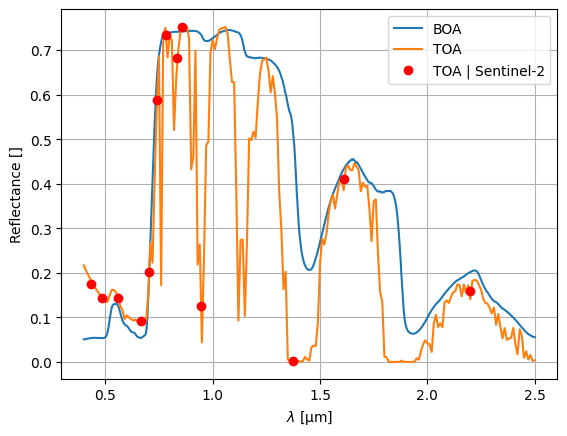

In [ ]:

s.atmos_profile = p6s.AtmosProfile.UserWaterAndOzone(3.6, 0.9) # Set the atmosphere profile to be based on 3.6cm of water and 0.9cm-atm of ozone
s.atmos_profile_oz50 = p6s.AtmosProfile.UserWaterAndOzone(3.6, 50)
s.atmos_profile_wa50 = p6s.AtmosProfile.UserWaterAndOzone(50, 0.9)
s.visibility = 1
# Set the altitudes
# s.altitudes.set_target_sea_level()
# s.altitudes.set_sensor_satellite_level()
# # Set ground reflectance
# s.ground_reflectance = GroundReflectance.HomogeneousLambertian(spectrum)
# Get the output for TOA
wv_vnir, R_vnir = p6s.SixSHelpers.Wavelengths.run_wavelengths(s, wls_prosail[::10]/1000, output_name="apparent_reflectance")
# Get the output for TOA for Sentinel-2
wv_msi, R_msi = p6s.SixSHelpers.Wavelengths.run_s2a_msi(s, output_name="apparent_reflectance")

# Plot
plt.plot(wls_prosail/1e3,rr, label="BOA")
plt.plot(wv_vnir,R_vnir,label="TOA")
plt.plot(wv_msi,R_msi,'ro',label="TOA | Sentinel-2")
plt.xlabel("$\lambda$ [µm]")
plt.ylabel("Reflectance []")
plt.grid()
plt.legend()

### Tweak observation geometry
Here we run the same again, but chaning the zenith angle of the sensor and the zenith angle of the Sun

Running for many wavelengths - this may take a long time
Running for many wavelengths - this may take a long time


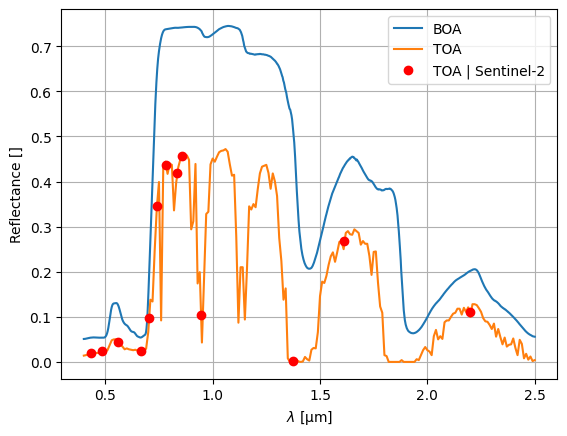

In [17]:
s.atmos_profile = p6s.AtmosProfile.UserWaterAndOzone(2, 0.9) # Set the atmosphere profile to be based on 3.6cm of water and 0.9cm-atm of ozone
s.visibility = 1
s.geometry.view_z = 10
s.geometry.solar_z = 50
# Set the altitudes
# s.altitudes.set_target_sea_level()
# s.altitudes.set_sensor_satellite_level()
# # Set ground reflectance
# s.ground_reflectance = GroundReflectance.HomogeneousLambertian(spectrum)
# Get the output for TOA
wv_vnir, R_vnir = p6s.SixSHelpers.Wavelengths.run_wavelengths(s, wls_prosail[::10]/1000, output_name="pixel_reflectance")
# Get the output for TOA for Sentinel-2
wv_msi, R_msi = p6s.SixSHelpers.Wavelengths.run_s2a_msi(s, output_name="pixel_reflectance")

# Plot
plt.plot(wls_prosail/1e3,rr, label="BOA")
plt.plot(wv_vnir,R_vnir,label="TOA")
plt.plot(wv_msi,R_msi,'ro',label="TOA | Sentinel-2")
plt.xlabel("$\lambda$ [µm]")
plt.ylabel("Reflectance []")
plt.grid()
plt.legend()